##### <b>Step-1: Importing Libraries</b>

In [2]:
import os, shutil, sys, cv2, time                              

import numpy as np
import pandas as pd
from skimage import transform
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image  
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics

# import sklearn.metrics as metrics

In [3]:
np.random.seed(0)

##### <b>Step-2: Setting path for Testing, Training and validation directories</b>

In [4]:
train_dir = './Train'
val_dir = './Validation'
test_dir = './Test'

for d in [train_dir, val_dir, test_dir]:
    try:
        os.mkdir(d)
    except FileExistsError:
        pass
    except:
        print('Error occurred.')

##### <b>Step-3: Setting path for classes</b>

In [5]:
train_covid_dir = './Train/COVID'
train_normal_dir = './Train/Normal'

val_covid_dir = './Validation/COVID'
val_normal_dir = './Validation/Normal'

test_covid_dir = './Test/COVID'
test_normal_dir = './Test/Normal'


for d in [train_covid_dir, train_normal_dir, val_covid_dir, val_normal_dir, test_covid_dir, test_normal_dir]:
    try:
        os.mkdir(d)
    except FileExistsError:
        pass
    except:
        print('Error occurred.')

In [6]:
os.listdir(os.path.join(base, 'COVID'))

['images', 'masks']

In [7]:
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1  # 0.7, 0.15, 0.15

base = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset';
for d in os.listdir(base):
    if os.path.isdir(os.path.join(base, d)) and d not in ['Viral Pneumonia', 'Lung_Opacity']:
        files = os.listdir(os.path.join(base, d, 'images'))
        train_files = np.random.choice(files, int(train_ratio*len(files)), replace=False)
        val_files = np.random.choice(list(set(files) - set(train_files)), int(val_ratio*len(files)), replace=False)
        test_files = list(set(files) - set(train_files)- set(val_files))
        
        print(d, len(files))
        print('Train: {0:d},   Val: {1:d},   Test: {2:d}'.format(len(train_files), len(val_files), len(test_files)))
        for f, root in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
            for file in tqdm(f, desc=root[2:]):
                try:
                    shutil.copy(os.path.join(base, d, 'images', file), os.path.join(root, d, file))
                except FileExistsError:
                    pass
                except:
                    print('Error occurred.')

Normal 10192
Train: 8153,   Val: 1019,   Test: 1020


Train:   0%|          | 0/8153 [00:00<?, ?it/s]

Validation:   0%|          | 0/1019 [00:00<?, ?it/s]

Test:   0%|          | 0/1020 [00:00<?, ?it/s]

COVID 3616
Train: 2892,   Val: 361,   Test: 363


Train:   0%|          | 0/2892 [00:00<?, ?it/s]

Validation:   0%|          | 0/361 [00:00<?, ?it/s]

Test:   0%|          | 0/363 [00:00<?, ?it/s]

##### <b>Step-4: Printing Total Images of each class</b>

In [8]:
num_covid_train = len(os.listdir(train_covid_dir))
num_normal_train = len(os.listdir(train_normal_dir))

num_covid_validaition = len(os.listdir(val_covid_dir))
num_normal_validation= len(os.listdir(val_normal_dir))

num_covid_test = len(os.listdir(test_covid_dir))
num_normal_test= len(os.listdir(test_normal_dir))

print("Total Training COVID Images",num_covid_train)
print("Total Training NORMAL Images",num_normal_train)

print("-"*40)
print("Total validation COVID Images",num_covid_validaition)
print("Total validation NORMAL Images",num_normal_validation)

print("-"*40)
print("Total Test COVID Images", num_covid_test)
print("Total Test NORMAL Images",num_normal_test)

print("-"*100)
total_train = num_covid_train+num_normal_train
total_validation = num_covid_validaition+num_normal_validation
total_test = num_covid_test+num_normal_test
print("Total Training Images",total_train)
print("Total Validation Images",total_validation)
print("Total Testing Images",total_test)

Total Training COVID Images 2892
Total Training NORMAL Images 8153
----------------------------------------
Total validation COVID Images 361
Total validation NORMAL Images 1019
----------------------------------------
Total Test COVID Images 363
Total Test NORMAL Images 1020
----------------------------------------------------------------------------------------------------
Total Training Images 11045
Total Validation Images 1380
Total Testing Images 1383


##### <b>Step-5: Defining Image shape and batch size for Convolutional neural networks</b>

In [9]:
IMG_SHAPE  = 150 # 224
batch_size = 32  # 50

##### <b>Step-6: Function for visualization of images</b>

In [10]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

##### <b>Step-7:Applying Data Augmentation on training data</b>

In [11]:
image_gen_train = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, #10
                                     width_shift_range=0.1, #0.1
                                     height_shift_range=0.1, #0.1
                                     shear_range = 0.1, #0
                                     zoom_range = 0.1, #0.1
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle= True,
                                                     target_size = (IMG_SHAPE, IMG_SHAPE),
                                                    class_mode  = "categorical")

Found 11045 images belonging to 2 classes.


##### <b>Step-8: showing augmented images</b>

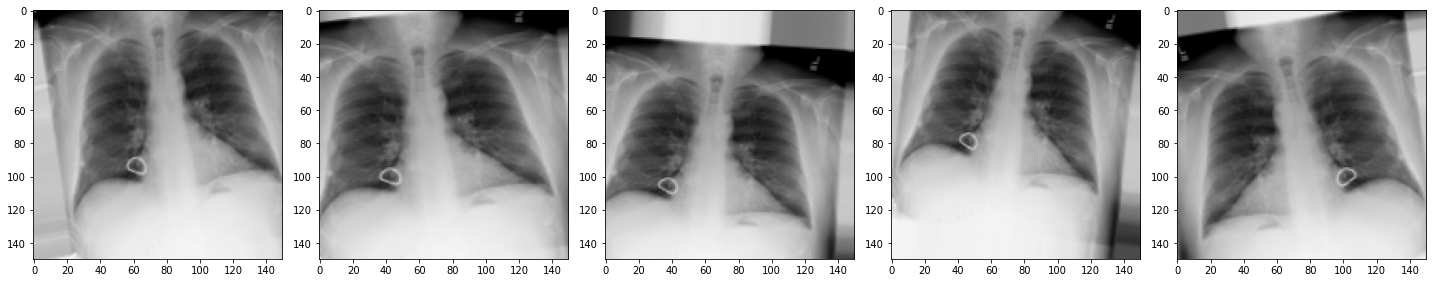

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(20)]  # Extract first image from each training batch
plotImages(augmented_images)  # Show first 5 images

##### <b>Step-9: Preprocessing of validation and testing data</b>

In [13]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=50,
                                                 directory=test_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


##### <b>Step-10: building Convolutional Neural Networks</b>

In [15]:
kernel_size = (3,3)
pool_size= (2,2)
dropout_conv = 0.2
dropout_dense = 0.2

classifier = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size, activation='relu', padding="same", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),
    
    tf.keras.layers.Conv2D(32, kernel_size, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),
    
    tf.keras.layers.Conv2D(64, kernel_size,padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),
    
    tf.keras.layers.Conv2D(128, kernel_size, padding="same", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=pool_size),
    
#Fully conected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(128, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(2, activation= "softmax")
])

### VGG 16 Style network
# classifier = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
#     tf.keras.layers.Conv2D(64, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(pool_size=pool_size),

#     tf.keras.layers.Conv2D(128, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(128, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(pool_size=pool_size),

#     tf.keras.layers.Conv2D(256, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(256, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(256, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.MaxPooling2D(pool_size=pool_size),

#     tf.keras.layers.Conv2D(512, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(512, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(512, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.MaxPooling2D(pool_size=pool_size),

#     tf.keras.layers.Conv2D(512, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(512, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.Conv2D(512, kernel_size, padding="same", activation="relu"),
#     tf.keras.layers.MaxPooling2D(pool_size=pool_size),

# #Fully conected
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation ="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation ="relu"),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(3, activation= "softmax")
# ])

In [16]:
#classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy', metrics.Precision(), metrics.Recall()])
classifier.compile(optimizer = Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['acc', metrics.Precision(), metrics.Recall()])
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        1

##### <b>Step-11: Training the Convolutional Neural Networks</b>

In [18]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=3, min_lr=0.0001)

In [20]:
class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, name='best_model.h5'):
        super(CustomModelCheckpoint, self).__init__()
        self.name = name
        self.cur_train_acc = 0
        self.cur_val_acc   = 0
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
        if logs['val_acc'] > self.cur_val_acc and logs['acc'] > self.cur_train_acc: # your custom condition
            self.model.save(self.name, overwrite=True)
            self.cur_train_acc, self.cur_val_acc = (logs['acc'], logs['val_acc'])
            print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")

In [22]:
history = classifier.fit(train_data_gen, 
                         steps_per_epoch=100, #28, #180
                         epochs = 5,#50, #200
                         validation_data=val_data_gen,
                         verbose = 1,
                         callbacks = [CustomModelCheckpoint(name='2_COVID_CNN_best.h5'), reduce_lr])

Epoch 1/5
100/100 [==============================] - 27s 266ms/step - loss: 0.2890 - acc: 0.8769 - precision: 0.8769 - recall: 0.8769 - val_loss: 0.2700 - val_acc: 0.8797 - val_precision: 0.8797 - val_recall: 0.8797
epoch: 0, train_acc: 0.8768749833106995, valid_acc: 0.8797101378440857
Epoch 2/5
100/100 [==============================] - 27s 266ms/step - loss: 0.2514 - acc: 0.8959 - precision: 0.8959 - recall: 0.8959 - val_loss: 1.9550 - val_acc: 0.3841 - val_precision: 0.3841 - val_recall: 0.3841
Epoch 3/5
100/100 [==============================] - 27s 268ms/step - loss: 0.2263 - acc: 0.9083 - precision: 0.9083 - recall: 0.9083 - val_loss: 1.8821 - val_acc: 0.4993 - val_precision: 0.4993 - val_recall: 0.4993
Epoch 4/5
100/100 [==============================] - 26s 265ms/step - loss: 0.2247 - acc: 0.9127 - precision: 0.9127 - recall: 0.9127 - val_loss: 0.8280 - val_acc: 0.6913 - val_precision: 0.6913 - val_recall: 0.6913
Epoch 5/5
100/100 [==============================] - 27s 266ms/st

    150
    acc: 0.9762 - precision: 0.9762 - recall: 0.9762 - val_loss: 0.0461 - val_acc: 0.9862 - val_precision: 0.9862 - val_recall: 0.9862


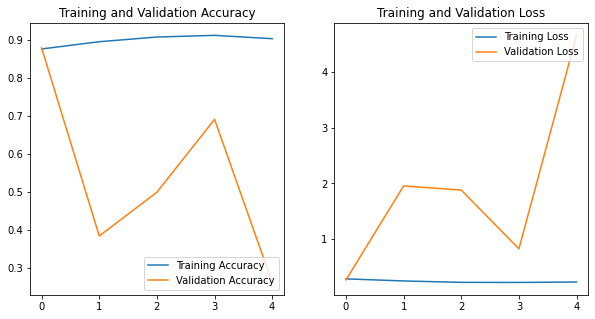

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('2_CNN_Accuracy_loss.png')
plt.savefig('2_CNN_Accuracy_loss.pdf', dpi=200)
plt.show()

In [ ]:
np.save('2_CNN_model_history.npy', history.history, allow_pickle=True)

##### <b>Step-12:Visualizing the training and validation using accuracy and loss in single graph </b>

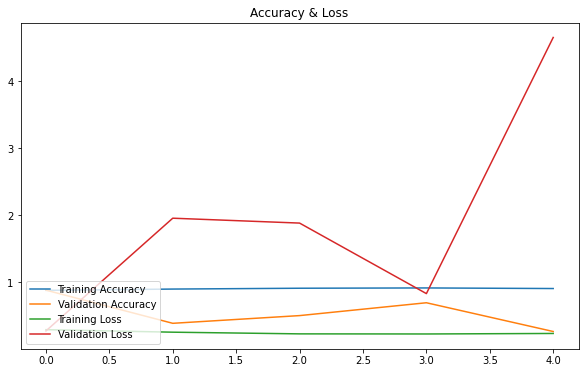

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Accuracy & Loss')
plt.show()

##### <b>Step-13:Saving model in json and h5 format</b>

In [25]:
model_json = classifier.to_json()
with open("2_COVID_CNN.json", "w") as json_file:
    json_file.write(model_json)
classifier.save('2_COVID_CNN.h5')

##### <b>Step-14: Testing Model on test data</b>

In [26]:
classifier = tf.keras.models.load_model('./2_COVID_CNN_best.h5')

In [27]:
results = classifier.evaluate(test_data_gen,batch_size=50)
print("test_loss, test accuracy",results)

28/28 [==============================] - 4s 132ms/step - loss: 0.2763 - acc: 0.8850 - precision: 0.8850 - recall: 0.8850
test_loss, test accuracy [0.2763257622718811, 0.8850325345993042, 0.8850325345993042, 0.8850325345993042]


    150
    test_loss, test accuracy [0.06662073731422424, 0.9869847893714905, 0.9869847893714905, 0.9869847893714905]

#####<b>Step-15:visualizing results with confidence</b>

The below image is  NORMAL  with  0.96  confidence


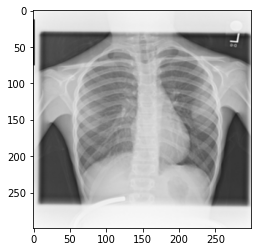

In [28]:
image_1 = cv2.imread(os.path.join(test_normal_dir, os.listdir(test_normal_dir)[0]))
image = cv2.resize(image_1, (IMG_SHAPE, IMG_SHAPE))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = classifier.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
    res = "COVID-19"
elif classes==1:
    res = "NORMAL"
confidence = str(round(max(predict[0]), 2))
plt.imshow(image_1)
print("The below image is ",res," with ",confidence," confidence")

The below image is  COVID-19  with  0.94  confidence


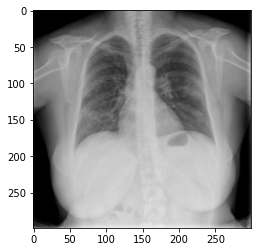

In [34]:
image_1 = cv2.imread(os.path.join(test_covid_dir, os.listdir(test_covid_dir)[150]))
image = cv2.resize(image_1, (IMG_SHAPE, IMG_SHAPE))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = classifier.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
    res = "COVID-19"
elif classes==1:
    res = "NORMAL"
confidence = str(round(max(predict[0]), 2))
plt.imshow(image_1)
print("The below image is ",res," with ",confidence," confidence")

##### <b>Step-16: buliding a VGG-16 Model</b>

In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), include_top=False, 
                                                weights="imagenet")
for layer in pre_trained_model.layers:
#     print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

# x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Sequential([pre_trained_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(128, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(2, activation= "softmax")])

In [ ]:
# model = tf.keras.Model(pre_trained_model.input, x)
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                                     decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc', metrics.Precision(), metrics.Recall()])

model.summary()

##### <b>Step-18:Training VGG-16 Model with Fine Tuning</b>

In [ ]:
# for layer in model.layers[:15]:
#     layer.trainable = False

# for layer in model.layers[15:]:
#     layer.trainable = True

In [ ]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, 
                                                               verbose=1, factor=0.5, 
                                                               min_lr=0.000001, cooldown=3)

In [ ]:
epochs = 50
history_mod = model.fit(train_data_gen,epochs = epochs, validation_data = val_data_gen,verbose = 1, 
                        steps_per_epoch=150, validation_steps=11, callbacks=[CustomModelCheckpoint(name='2_COVID_VGG16_With_Tunning_best.h5'), reduce_lr])

    150
    acc: 0.9661 - precision_4: 0.9661 - recall_4: 0.9661 - val_loss: 0.0874 - val_acc: 0.9801 - val_precision_4: 0.9801 - val_recall_4: 0.9801

##### <b>Step-19:Visualizing the training and validation using accuracy and loss in single graph </b>

In [ ]:
acc = history_mod.history['acc']
val_acc = history_mod.history['val_acc']

loss = history_mod.history['loss']
val_loss = history_mod.history['val_loss']

epochs_range = range(epochs)

epochs_range = range(len(loss))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('2_VGG16_Accuracy_loss.png')
plt.savefig('2_VGG16_Accuracy_loss.pdf', dpi=200)
plt.show()

##### <b>Step-20:Saving VGG-16 model in json and h5 format</b>

In [ ]:
model = tf.keras.models.load_model('./2_COVID_VGG16_With_Tunning_best.h5')
model_json = model.to_json()
with open("2_COVID_VGG16_With_Tuning.json", "w") as json_file:
    json_file.write(model_json)
model.save('2_COVID_VGG16_With_Tuning.h5')

##### <b>Step-21: Testing VGG-16 Model on Test Data</b>

In [ ]:
results = model.evaluate(test_data_gen, batch_size=50)
print("test_loss, test accuracy",results)


    150
    test_loss, test accuracy [0.16507935523986816, 0.9428778290748596, 0.9428778290748596, 0.9428778290748596]

In [ ]:
results = model.predict(test_data_gen, steps = np.ceil(num_covid_test+num_normal_test/50))
results.shape

##### <b>Step-22: Visualizing Result of VGG-16 Model with Confidence</b>

In [ ]:
model = tf.keras.models.load_model('./2_COVID_VGG16_With_Tunning_best.h5')
image_1 = cv2.imread(os.path.join(test_normal_dir, os.listdir(test_normal_dir)[0]))
heatmap_img = cv2.applyColorMap(image_1, cv2.COLORMAP_JET)
image = cv2.resize(image_1, (IMG_SHAPE, IMG_SHAPE))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = model.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
  res = "COVID-19"
elif classes==1:
  res = "NORMAL"
confidence = str(round(max(predict[0]), 2))

plt.figure(figsize=(10,10))
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(image_1)
axarr[0].axis("off")
axarr[1].imshow(heatmap_img)
axarr[1].axis("off")
print('Model has {} confidence,that image is of {} class.'.format(confidence,res))

In [30]:
image_2 = cv2.imread(os.path.join(test_covid_dir, os.listdir(test_covid_dir)[0]))
heatmap_img = cv2.applyColorMap(image_2, cv2.COLORMAP_JET)
image = cv2.resize(image_2, (IMG_SHAPE, IMG_SHAPE))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = model.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
    res = "COVID-19"
elif classes==1:
      res = "NORMAL"
confidence = str(round(max(predict[0]), 2))
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(image_2)
axarr[0].axis("off")
axarr[1].imshow(heatmap_img)
axarr[1].axis("off")
print('Model has {} confidence,that image is of {} class.'.format(confidence,res))

NameError: name 'model' is not defined

In [ ]:
covid_image = cv2.imread(os.path.join(test_covid_dir, os.listdir(test_covid_dir)[0]))
covid_image_1 = cv2.imread(os.path.join(test_covid_dir, os.listdir(test_covid_dir)[1]))
normal_image = cv2.imread(os.path.join(test_normal_dir, os.listdir(test_normal_dir)[0]))
normal_image_2 = cv2.imread(os.path.join(test_normal_dir, os.listdir(test_normal_dir)[1]))

fig, axarr = plt.subplots(1, 4, figsize=(20,20))
axarr[0].imshow(covid_image)
axarr[0].axis("off")
axarr[1].imshow(normal_image)
axarr[1].axis("off")
axarr[2].imshow(covid_image_1)
axarr[2].axis("off")
axarr[3].imshow(normal_image_2)
axarr[3].axis("off")
plt.show()

### VGG-19 Model

In [ ]:
pre_trained_model = tf.keras.applications.VGG19(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), include_top=False, 
                                                weights="imagenet")
for layer in pre_trained_model.layers:
#     print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_dense)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_dense)(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                                     decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc', metrics.Precision(), metrics.Recall()])

model.summary()

In [ ]:
epochs = 40
history_mod = model.fit(train_data_gen,epochs = epochs, validation_data = val_data_gen,verbose = 1, 
                        steps_per_epoch=150, validation_steps=11, 
                        callbacks=[CustomModelCheckpoint(name='2_COVID_VGG19_Tunning_best.h5'), reduce_lr])

    150
    acc: 0.8954 - precision_2: 0.8954 - recall_2: 0.8954 - val_loss: 0.1802 - val_acc: 0.9261 - val_precision_2: 0.9261 - val_recall_2: 0.9261

In [ ]:
model_json = model.to_json()
with open("2_COVID_19_VGG19_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save('2_COVID_19_VGG19-Classifier.h5')

In [ ]:
model = load_model('./2_COVID_VGG19_Tunning_best.h5')
results = model.evaluate(test_data_gen, batch_size=50)
print("test_loss, test accuracy",results)

    150
    test_loss, test accuracy [0.1766190528869629, 0.9255242347717285, 0.9255242347717285, 0.9255242347717285]

## ResNet50

In [ ]:
pre_trained_model = tf.keras.applications.ResNet50(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), include_top=False, 
                                                weights="imagenet")
for layer in pre_trained_model.layers:
#     print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))
last_layer = pre_trained_model.get_layer('conv5_block3_out')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Sequential([pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(128, activation ="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(2, activation= "softmax")])
    
# model = tf.keras.Model(pre_trained_model.input, x)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                                     decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc', metrics.Precision(), metrics.Recall()])

model.summary()

In [ ]:
epochs = 40
history_mod = model.fit(train_data_gen,epochs = epochs, validation_data = val_data_gen,verbose = 1, 
                        steps_per_epoch=150, validation_steps=11, 
                        callbacks=[CustomModelCheckpoint(name='2_COVID_ResNet50_Tunning_best.h5'), reduce_lr])

In [ ]:
model_json = model.to_json()
with open("2_COVID_19_ResNet50_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save('2_COVID_19_ResNet50-Classifier.h5')

In [ ]:
model = load_model('./2_COVID_ResNet50_Tunning_best.h5')
results = model.evaluate(test_data_gen, batch_size=50)
print("test_loss, test accuracy",results)

In [ ]:
acc = history_mod.history['acc']
val_acc = history_mod.history['val_acc']

loss = history_mod.history['loss']
val_loss = history_mod.history['val_loss']

epochs_range = range(epochs)

epochs_range = range(len(loss))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('2_ResNet50_Accuracy_loss.png')
plt.savefig('2_ResNet50_Accuracy_loss.pdf', dpi=200)
plt.show()

### Inception

In [ ]:
pre_trained_model = tf.keras.applications.InceptionResNetV2(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), include_top=False, 
                                                weights="imagenet")
for layer in pre_trained_model.layers:
#     print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))
# last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', pre_trained_model.output_shape)
last_output = pre_trained_model.output

x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_dense)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(dropout_dense)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, 
                                     decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc', metrics.Precision(), metrics.Recall()])

model.summary()

In [ ]:
epochs = 40
history_mod = model.fit(train_data_gen,epochs = epochs, validation_data = val_data_gen,verbose = 1, 
                        steps_per_epoch=150, validation_steps=11, 
                        callbacks=[CustomModelCheckpoint(name='2_COVID_Inception_Tunning_best.h5'), reduce_lr])

    150
    acc: 0.9005 - precision_3: 0.9005 - recall_3: 0.9005 - val_loss: 0.1584 - val_acc: 0.9318 - val_precision_3: 0.9318 - val_recall_3: 0.9318

In [ ]:
model_json = model.to_json()
with open("2_COVID_19_Inception_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save('2_COVID_19_Inception-Classifier.h5')

In [ ]:
model = load_model('./2_COVID_Inception_Tunning_best.h5')
results = model.evaluate(test_data_gen, batch_size=50)
print("test_loss, test accuracy",results)

    150
    test_loss, test accuracy [0.2089494913816452, 0.9211858510971069, 0.9211858510971069, 0.9211858510971069]

In [ ]:
acc = history_mod.history['acc']
val_acc = history_mod.history['val_acc']

loss = history_mod.history['loss']
val_loss = history_mod.history['val_loss']

epochs_range = range(epochs)

epochs_range = range(len(loss))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('2_Inception_Accuracy_loss.png')
plt.savefig('2_Inception_Accuracy_loss.pdf', dpi=200)
plt.show()

### Model display

In [17]:
model = load_model('../input/covid19-saved-models/2_COVID_VGG19_Tunning_best.h5')
flat_output = tf.keras.models.Model(inputs=model.input, outputs=model.layers[23].output)
pd.DataFrame(flat_output.predict(test_data_gen)).to_csv('2_COVID_VGG19_best..csv')

2022-11-27 18:04:46.285787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 18:04:46.404585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 18:04:46.405390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 18:04:46.406672: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model = load_model('../input/covid19-saved-models/2_COVID_CNN_best.h5')
flat_output = tf.keras.models.Model(inputs=model.input, outputs=model.layers[12].output)
pd.DataFrame(flat_output.predict(test_data_gen)).to_csv('2_COVID_CNN_best.csv', header=False, index=False)

model = load_model('../input/covid19-saved-models/2_COVID_VGG16_With_Tunning_best.h5')
flat_output = tf.keras.models.Model(inputs=model.input, outputs=model.layers[2].output)
pd.DataFrame(flat_output.predict(test_data_gen)).to_csv('2_COVID_VGG16_best.csv')

model = load_model('../input/covid19-saved-models/2_COVID_VGG19_Tunning_best.h5')
flat_output = tf.keras.models.Model(inputs=model.input, outputs=model.layers[23].output)
pd.DataFrame(flat_output.predict(test_data_gen)).to_csv('2_COVID_VGG19_best..csv')

## Stats test

In [ ]:
import numpy as np
from numpy.random import randn
from scipy.stats import friedmanchisquare
import matplotlib.pyplot as plt

np.random.seed(10)

data1 = np.clip(np.array([0.9228+0.1*randn(10)]).ravel(), 0, 1)
data2 = np.clip(np.array([0.9256+0.05*randn(10)]).ravel(), 0, 1)
data3 = np.clip(np.array([0.8960+0.01*randn(10)]).ravel(), 0, 1)
data4 = np.clip(np.array([0.8908+0.05*randn(10)]).ravel(), 0, 1)
data5 = np.clip(np.array([0.9927+0.1*randn(10)]).ravel(), 0, 1)

D = np.argsort(np.argsort(np.vstack((data1, data2, data3, data4, data5)), axis=0), axis=0)

stat, p = friedmanchisquare(D[0], D[1], D[2], D[3], D[4])
print('Average ranks', np.mean(D, axis=1))
print('Statistics=%.3f, p=%.10f' % (stat, p))

x = ['VGG-16', 'VGG-19', 'Inception-V3', 'ResNet-50', 'BNCNN']
y = np.round(np.mean(D, axis=1), 2)
plt.figure(figsize=(5, 3), dpi=100, frameon=False)
plt.grid(axis = 'y', linestyle = '--', linewidth = 1)
plt.bar(x, y, color=[(0, 0, 1, 0.8), (1, 0.5, 0, 0.9), 'g', 'r', (0.5, 0, 1, 0.8)])
plt.ylim([0, 4])
plt.yticks([0, 1, 2, 3])
plt.xticks(rotation=45)
plt.ylabel('Average ranking')
plt.subplots_adjust(bottom=0.3)
for i in range(len(x)):
        plt.text(i-0.2,y[i]+0.2,y[i])
plt.savefig('2_Avg_rank.png')
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame()
for name, data in zip(x, np.vstack((data1, data2, data3, data4, data5))):
    df[name] = data

# print(np.vstack((data1, data2, data3, data4, data5)))
# print(D)
df.head(10)

In [ ]:
df = df.stack().reset_index()
df = df.rename(columns={'level_0': 'id','level_1': 'Model', 0:'Accuracy'})
df.head()

In [ ]:
import scipy.stats as stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
# Set up the data for comparison (creates a specialised object)
MultiComp = MultiComparison(df['Accuracy'], df['Model'])
comp = MultiComp.allpairtest(stats.ttest_rel, method='Holm', alpha=0.05, pvalidx=1)
comp[0]

## **DLong Test**

In [52]:
targets = train_data_gen.labels

preds = pd.DataFrame()
cnn = load_model('../input/covid19-saved-models/2_COVID_CNN_best.h5')
preds['cnn'] = cnn.predict(train_data_gen)[:, 0]
vgg16 = load_model('../input/covid19-saved-models/2_COVID_VGG16_With_Tunning_best.h5')
preds['vgg16'] = cnn.predict(train_data_gen)[:, 0]
vgg19 = load_model('../input/covid19-saved-models/2_COVID_VGG19_Tunning_best.h5')
preds['vgg19'] = cnn.predict(train_data_gen)[:, 0]
# !pip install pyroc
import pyroc

R = pyroc.ROC(targets, preds)

In [53]:
R.auc

array([[0.49222904, 0.49711012, 0.49339355]])

In [57]:
R.ci()

array([[0.47999644, 0.48484938, 0.48117139],
       [0.50446163, 0.50937086, 0.50561571]])

In [54]:
print(R.preds.keys())

odict_keys(['cnn', 'vgg16', 'vgg19'])


In [56]:
p, ci = R.compare(np.array([
    [-1, 0,  1],
]))
print(p, ci)

0.895330197603249 [[-0.01618393  0.01851296]]


### ROC plot

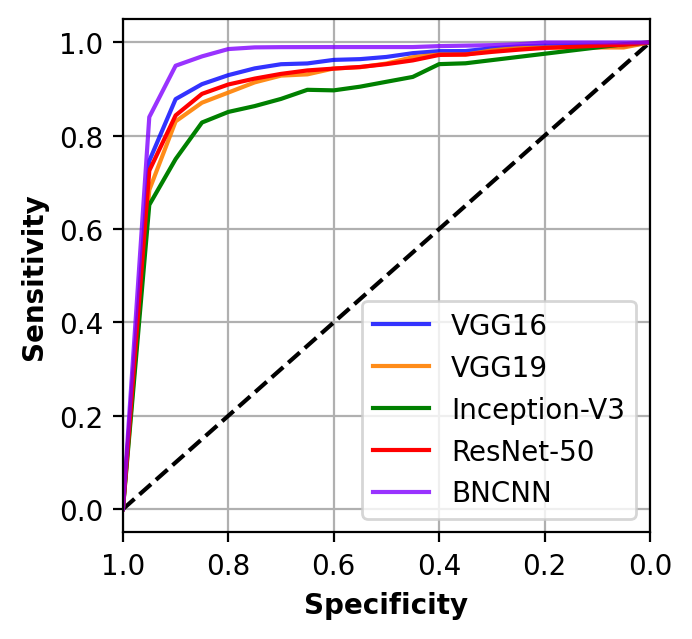

In [79]:
colors= [(0, 0, 1, 0.8), (1, 0.5, 0, 0.9), 'g', 'r', (0.5, 0, 1, 0.8)]

rocs = np.array([[0.0000, 0.7461, 0.8785, 0.9105, 0.9298, 0.9443, 0.9532, 0.9549, 0.9625, 0.9641, 0.9688, 0.9769, 0.9812, 0.9814, 0.9873, 0.9913, 0.9932, 0.9934, 0.9934, 0.9912, 1.0000],
[0.0000, 0.6836, 0.8308, 0.8708, 0.8925, 0.9143, 0.9288, 0.9315, 0.9441, 0.9468, 0.9547, 0.9682, 0.9740, 0.9737, 0.9828, 0.9882, 0.9887, 0.9890, 0.9890, 0.9890, 1.0000],
[0.0000, 0.6518, 0.7500, 0.8283, 0.8510, 0.8635, 0.8789, 0.8984, 0.8972, 0.9051, 0.9156, 0.9260, 0.9534, 0.9552, 0.9620, 0.9688, 0.9756, 0.9824, 0.9892, 0.9960, 1.0000],
[0.0000, 0.7251, 0.8436, 0.8897, 0.9098, 0.9224, 0.9325, 0.9399, 0.9438, 0.9473, 0.9534, 0.9614, 0.9731, 0.9740, 0.9796, 0.9843, 0.9881, 0.9904, 0.9927, 0.9950, 1.0000],
[0.0000, 0.8400, 0.9500, 0.9700, 0.9857, 0.9893, 0.9898, 0.9899, 0.9900, 0.9900, 0.9900, 0.9900, 0.9920, 0.9930, 0.9940, 0.9960, 0.9999, 0.9999, 0.9999, 0.9999, 1.0000],

[0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000, 0.4500, 0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000, 0.9500, 1.0000],
])

labels = ['VGG16', 'VGG19', 'Inception-V3', 'ResNet-50', 'BNCNN']

plt.figure(figsize=(3.4, 3.4), dpi=200)
plt.plot(1-np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), ls='--', color='k')
for c, r, lab in zip(colors, rocs, labels):
    plt.plot(1-rocs[-1], r, color=c, label=lab)

plt.xlim(1, 0)
plt.xlabel('Specificity', fontweight='bold')
plt.ylabel('Sensitivity', fontweight='bold')
plt.grid('major')
plt.legend()
plt.savefig('2_DLong_COVID.png', bbox_inches='tight')
plt.show()

In [ ]:
[0.0000, 0.5018, 0.6900, 0.7583, 0.8010, 0.8335, 0.8489, 0.8644, 0.8772, 0.8851, 0.8956, 0.9110, 0.9313, 0.9422, 0.9480, 0.9588, 0.9656, 0.9724, 0.9792, 0.9860, 1.0000],
[0.0000, 0.5190, 0.7103, 0.7958, 0.8325, 0.8610, 0.8742, 0.8891, 0.8995, 0.9061, 0.9169, 0.9478, 0.9443, 0.9522, 0.9579, 0.9589, 0.9700, 0.9759, 0.9805, 0.9920, 1.0000],




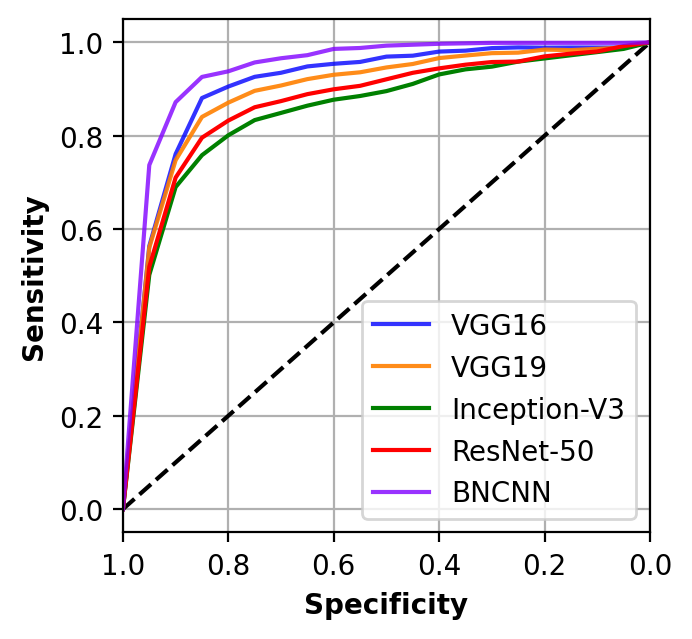